## 1.0 Environment & Data Ingestion

This section documents the configuration of the forensic environment and the ingestion of the Sparkov-generated dataset (Kartik2112). The objective is to establish a verified data baseline for fraud analysis.

In [ ]:
### 1.1 Configuration & Library Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import precision_recall_curve, recall_score, precision_score
from sklearn.metrics import fbeta_score, make_scorer
from xgboost import XGBClassifier
import imblearn
import shap
from sklearn.dummy import DummyClassifier
import joblib
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 120
sns.set_style('whitegrid')

print('All libraries imported successfully.')

All libraries imported successfully.


In [11]:
### 1.2 Data Ingestion & Schema Validation

train_df = pd.read_csv('data/raw/fraudTrain.csv')
test_df = pd.read_csv('data/raw/fraudTest.csv')

print('Training data shape:', train_df.shape)
print('Test data shape:', test_df.shape)
print()
train_df.head(3)

Training data shape: (1296675, 23)
Test data shape: (555719, 23)



,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


## 2.0 Data Integrity & Initial Transformation

We perform a standard integrity audit to verify data completeness and class balance before engineering forensic features.

In [12]:
### 2.1 Missing Value & Duplicate Audit

missing_count = train_df.isnull().sum().sum()
duplicate_count = train_df.duplicated().sum()

print(f'Missing Values: {missing_count}')
print(f'Duplicate Rows: {duplicate_count}')

# Class balance
fraud_ratio = train_df['is_fraud'].mean() * 100
fraud_count = train_df['is_fraud'].sum()
legit_count = len(train_df) - fraud_count
print(f'\nClass Balance:')
print(f'  Legitimate (0): {legit_count:,} ({100 - fraud_ratio:.2f}%)')
print(f'  Fraud (1):      {fraud_count:,} ({fraud_ratio:.2f}%)')
print(f'  Imbalance ratio: 1:{legit_count / fraud_count:.1f} (fraud:legitimate)')

if missing_count == 0 and duplicate_count == 0:
    print('\nData Integrity Confirmed: No anomalies detected.')

Missing Values: 0
Duplicate Rows: 0

Class Balance:
  Legitimate (0): 1,289,169 (99.42%)
  Fraud (1):      7,506 (0.58%)
  Imbalance ratio: 1:171.8 (fraud:legitimate)

Data Integrity Confirmed: No anomalies detected.


In [13]:
### 2.2 Temporal & Demographic Feature Derivation

# Convert datetime columns
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'])
train_df['dob'] = pd.to_datetime(train_df['dob'])

# Calculate age from transaction date and date of birth
train_df['age'] = (train_df['trans_date_trans_time'] - train_df['dob']).dt.days // 365

# Extract hour of day
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour

# Create age group bins
train_df['age_group'] = pd.cut(
    train_df['age'],
    bins=[0, 30, 50, 70, 120],
    labels=['<30', '30-50', '50-70', '70+']
)

print('Derived Features: Age, Hour, Age_Group created.')

Derived Features: Age, Hour, Age_Group created.


## 3.0 EDA: The 4-Pillar Investigation

A forensic exploratory analysis focusing on the "When, Who, How, and Where" of the adversarial behavior.

### 3.1 When: Temporal Signatures

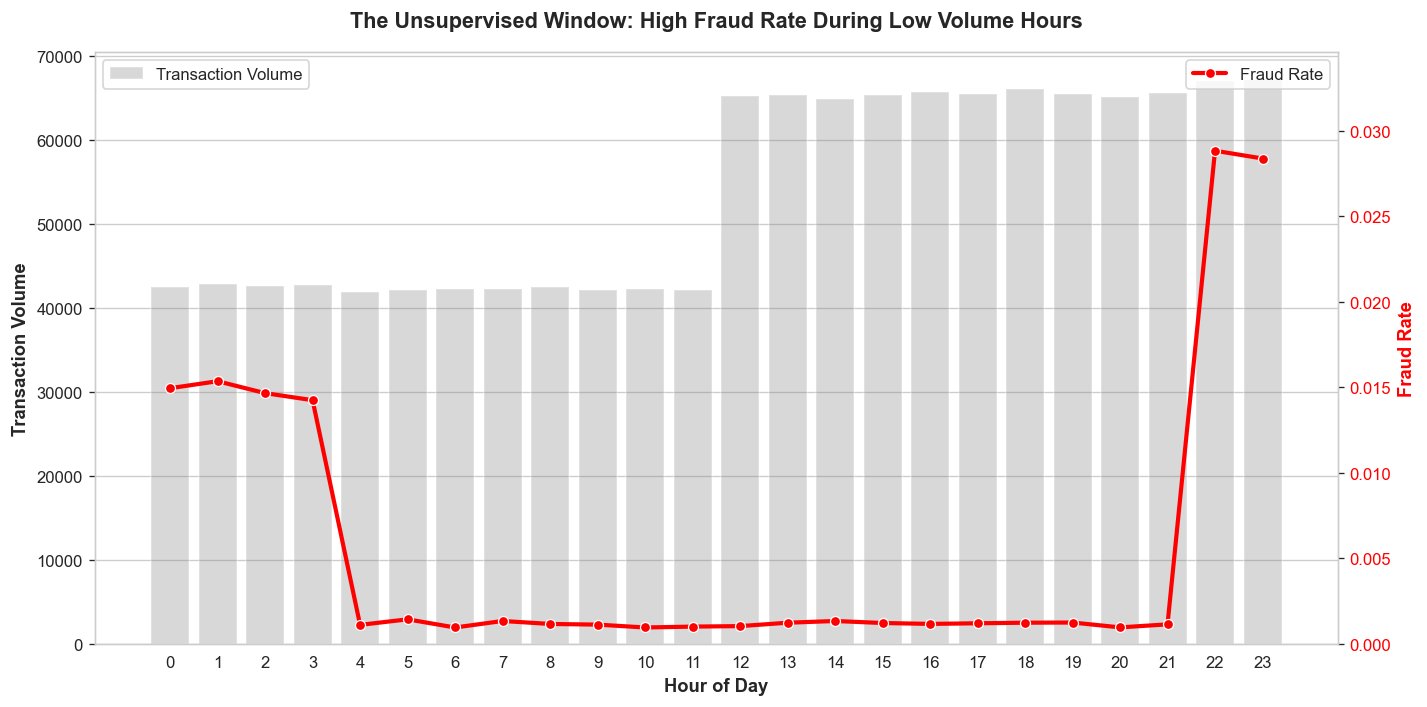

Peak fraud rate: Hour 22 (2.883%)
Peak transaction volume: Hour 23 (67,104 transactions)

Inverse relationship confirmed: High fraud rate during low volume hours.


In [14]:
hourly_stats = train_df.groupby('hour').agg(
    volume=('trans_num', 'count'),
    fraud_rate=('is_fraud', 'mean')
)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary axis: transaction volume (grey bars)
sns.barplot(
    x=hourly_stats.index, y=hourly_stats['volume'],
    alpha=0.3, color='grey', ax=ax1, label='Transaction Volume'
)
ax1.set_ylabel('Transaction Volume', fontsize=11, fontweight='bold')
ax1.set_xlabel('Hour of Day', fontsize=11, fontweight='bold')

# Secondary axis: fraud rate (red line)
ax2 = ax1.twinx()
sns.lineplot(
    x=hourly_stats.index, y=hourly_stats['fraud_rate'],
    color='red', marker='o', ax=ax2, label='Fraud Rate', linewidth=2.5
)
ax2.set_ylabel('Fraud Rate', fontsize=11, fontweight='bold', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, hourly_stats['fraud_rate'].max() * 1.2)

plt.title(
    'The Unsupervised Window: High Fraud Rate During Low Volume Hours',
    fontsize=13, fontweight='bold', pad=15
)
plt.grid(False)
fig.tight_layout()
plt.show()

peak_fraud_hour = hourly_stats['fraud_rate'].idxmax()
peak_volume_hour = hourly_stats['volume'].idxmax()
print(f'Peak fraud rate: Hour {peak_fraud_hour} ({hourly_stats.loc[peak_fraud_hour, "fraud_rate"]:.3%})')
print(f'Peak transaction volume: Hour {peak_volume_hour} ({hourly_stats.loc[peak_volume_hour, "volume"]:,} transactions)')
print(f'\nInverse relationship confirmed: High fraud rate during low volume hours.')

### 3.2 Who: Demographic Vulnerability

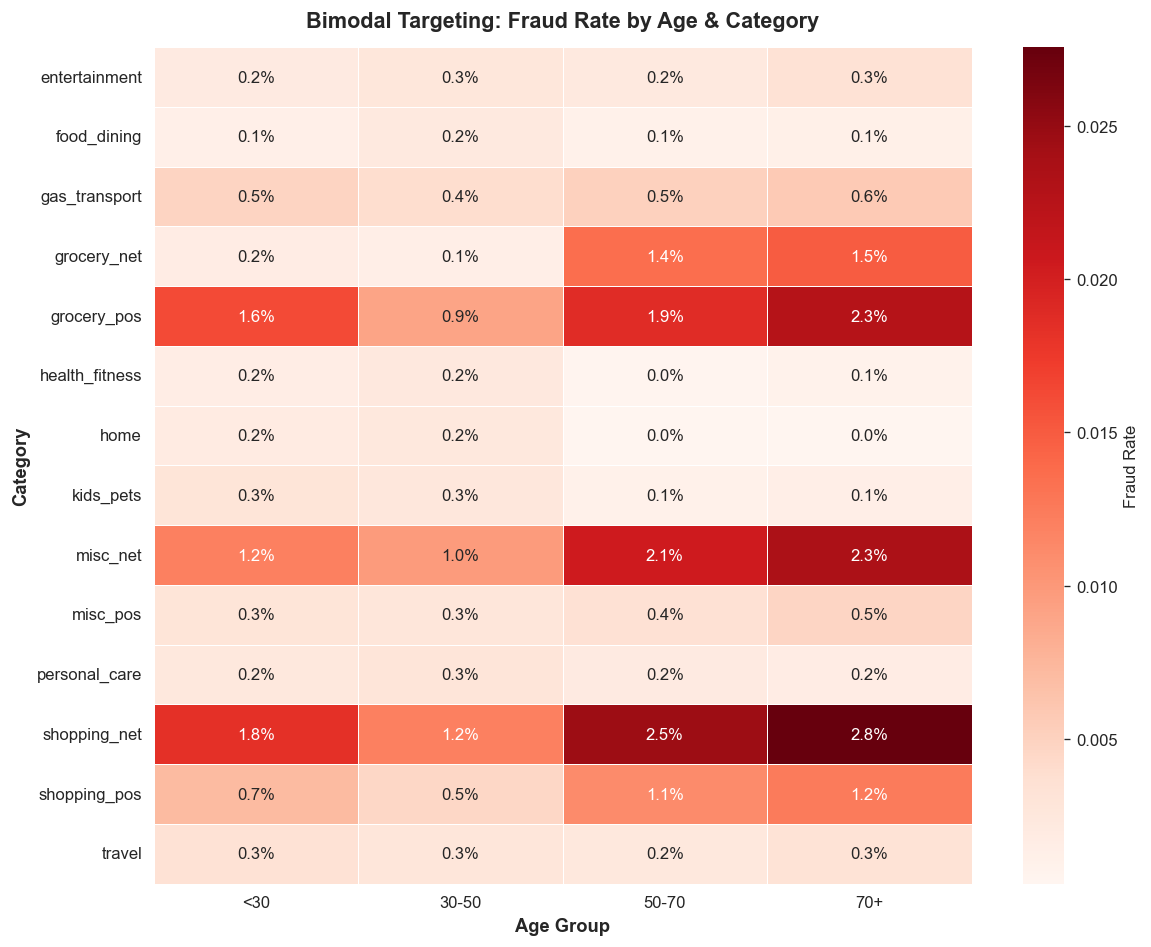

Top 10 Highest-Risk Age-Category Combinations:
  1. shopping_net (70+): 2.76%
  2. shopping_net (50-70): 2.45%
  3. misc_net (70+): 2.35%
  4. grocery_pos (70+): 2.27%
  5. misc_net (50-70): 2.05%
  6. grocery_pos (50-70): 1.88%
  7. shopping_net (<30): 1.83%
  8. grocery_pos (<30): 1.63%
  9. grocery_net (70+): 1.50%
  10. grocery_net (50-70): 1.35%


In [15]:


age_cat_risk = train_df.pivot_table(
    index='category', columns='age_group',
    values='is_fraud', aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    age_cat_risk, cmap='Reds', annot=True, fmt='.1%',
    cbar_kws={'label': 'Fraud Rate'}, linewidths=0.5
)
plt.title(
    'Bimodal Targeting: Fraud Rate by Age & Category',
    fontsize=13, fontweight='bold', pad=12
)
plt.xlabel('Age Group', fontsize=11, fontweight='bold')
plt.ylabel('Category', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# Print highest-risk combinations
print('Top 10 Highest-Risk Age-Category Combinations:')
age_cat_flat = age_cat_risk.stack().sort_values(ascending=False)
for idx, (cat_age, rate) in enumerate(age_cat_flat.head(10).items(), 1):
    print(f'  {idx}. {cat_age[0]} ({cat_age[1]}): {rate:.2%}')

### 3.3 How: Behavioral Displacement

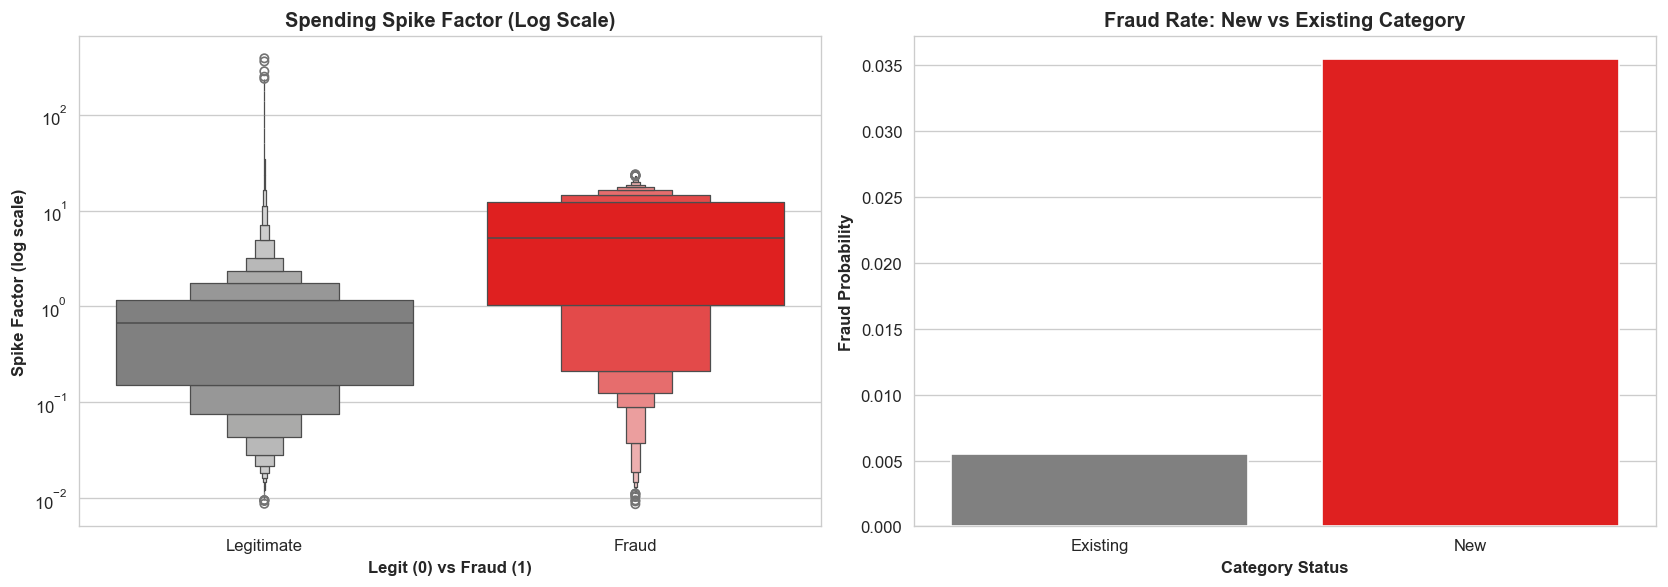

Spending Spike Analysis:
  Median spike (Legitimate): 0.67x
  Median spike (Fraud):      5.18x

Category Shift Analysis:
  Fraud rate (Existing category): 0.5486%
  Fraud rate (New category):      3.5452%
  Risk multiplier: 6.46x


In [16]:

# Spending spike factor: transaction amount relative to cardholder average
train_df['avg_card_amt'] = train_df.groupby('cc_num')['amt'].transform('mean')
train_df['spike_factor'] = train_df['amt'] / train_df['avg_card_amt']

# Category shift: flag first-time category usage per cardholder
train_df = train_df.sort_values(['cc_num', 'trans_date_trans_time'])
train_df['cat_cumcount'] = train_df.groupby(['cc_num', 'category']).cumcount()
train_df['is_new_category'] = train_df['cat_cumcount'] == 0

# Side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Spending Spike (Boxenplot, Log Scale)
sns.boxenplot(
    data=train_df, x='is_fraud', y='spike_factor',
    ax=axes[0], palette=['grey', 'red']
)
axes[0].set_yscale('log')
axes[0].set_title('Spending Spike Factor (Log Scale)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Legit (0) vs Fraud (1)', fontsize=10, fontweight='bold')
axes[0].set_ylabel('Spike Factor (log scale)', fontsize=10, fontweight='bold')
axes[0].set_xticklabels(['Legitimate', 'Fraud'])

# Right: Category Shift (Barplot)
category_fraud_rate = train_df.groupby('is_new_category')['is_fraud'].mean()
sns.barplot(
    x=[False, True], y=category_fraud_rate.values,
    ax=axes[1], palette=['grey', 'red']
)
axes[1].set_title('Fraud Rate: New vs Existing Category', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Category Status', fontsize=10, fontweight='bold')
axes[1].set_ylabel('Fraud Probability', fontsize=10, fontweight='bold')
axes[1].set_xticklabels(['Existing', 'New'])

plt.tight_layout()
plt.show()

# Print statistics
print('Spending Spike Analysis:')
print(f'  Median spike (Legitimate): {train_df[train_df["is_fraud"] == 0]["spike_factor"].median():.2f}x')
print(f'  Median spike (Fraud):      {train_df[train_df["is_fraud"] == 1]["spike_factor"].median():.2f}x')
print(f'\nCategory Shift Analysis:')
print(f'  Fraud rate (Existing category): {category_fraud_rate[False]:.4%}')
print(f'  Fraud rate (New category):      {category_fraud_rate[True]:.4%}')
print(f'  Risk multiplier: {category_fraud_rate[True] / category_fraud_rate[False]:.2f}x')

### 3.4 Where: Geospatial Assessment

**Forensic Audit Note:**

A detailed audit in [`geospatial_neutrality_report.ipynb`](geospatial_neutrality_report.ipynb) confirms that geospatial features (coordinates, state, city_pop) are **statistically neutral** in this dataset:

- **State Targeting:** r ≈ 1.0 — fraud is uniformly distributed across all states.
- **Velocity:** Zero recall on travelers with impossible speeds (>100 km/h) — the attack vector is digital/remote.
- **Population Density:** No distinction between urban and rural targeting — distributions overlap completely.

**Decision:** Geospatial features are excluded from the primary modeling pipeline to prevent noise injection. The model will focus exclusively on behavioral and temporal signals that demonstrate discriminatory power in this synthetic dataset.

## 4.0 Feature Engineering: Behavioral Baseline Construction

We initialize the forensic timeline for both training and test sets. Crucially, we derive the 'Age' and 'Cyclical Time' features immediately to ensure downstream dependencies are met.

In [17]:
dfs = [train_df, test_df]

for i, df in enumerate(dfs):
    # Datetime conversion (both timestamp and dob)
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])

    # Age derivation (must precede downstream age_group mapping)
    df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

    # Chronological sort
    df.sort_values(['cc_num', 'trans_date_trans_time'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Temporal features
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['is_night_window'] = df['hour'].isin([22, 23, 0, 1, 2, 3]).astype(int)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

### 4.2 Behavioral Patterns (Zero-Leakage)

We construct card-level baselines using strictly past-facing windows to prevent look-ahead bias. Logic is applied identically to train and test sets.

In [18]:
for i, df in enumerate(dfs):
    # Time since last transaction (seconds)
    df['time_since_last'] = (
        df.groupby('cc_num')['trans_date_trans_time']
        .diff().dt.total_seconds().fillna(0)
    )

    cat_counts = df.groupby(['cc_num', 'category']).cumcount()
    card_history_index = df.groupby('cc_num').cumcount()

# "New Category" if it's the 1st time for the category 
# AND it's at least the 11th transaction for that cc.
    df['is_new_category'] = ((cat_counts == 0) & (card_history_index >= 10)).astype(int)

    # Spike factor (expanding median, shifted to exclude current row)
    df.drop(columns=['spike_factor', 'avg_card_amt'], errors='ignore', inplace=True)
    expanding_med = (
        df.groupby('cc_num')['amt']
        .expanding().median()
        .groupby(level=0).shift(1)
        .reset_index(level=0, drop=True)
    )
    df['spike_factor'] = (df['amt'] / expanding_med).fillna(1.0)

    # Velocity windows (closed='left' excludes current transaction)
    df.set_index('trans_date_trans_time', inplace=True)

    df['trans_count_24h'] = (
        df.groupby('cc_num')['amt']
        .rolling('24h', closed='left').count()
        .reset_index(level=0, drop=True)
    )
    df['trans_count_7d'] = (
        df.groupby('cc_num')['amt']
        .rolling('7D', closed='left').count()
        .reset_index(level=0, drop=True)
    )
    df['trans_count_30d'] = (
        df.groupby('cc_num')['amt']
        .rolling('30D', closed='left').count()
        .reset_index(level=0, drop=True)
    )

    # Velocity burst ratio (+1 smoothing prevents division by zero)
    df['velocity_burst_24h'] = (
        df['trans_count_24h'] / ((df['trans_count_30d'] / 30) + 1)
    )

    df.reset_index(inplace=True)
    dfs[i] = df

train_df, test_df = dfs

### 4.3 Demographic Risk & Neutrality Purge

We map the derived 'Age' feature to forensic bins and execute the Neutrality Purge, removing raw geospatial columns and personal identifiers.

In [19]:
drop_cols = [
    'lat', 'long', 'merch_lat', 'merch_long', 'state', 'zip', 'city_pop',
    'first', 'last', 'street', 'city', 'job', 'trans_num', 'unix_time',
    'dob', 'age',
]

for df in [train_df, test_df]:
    df['age_group'] = pd.cut(
        df['age'], bins=[0, 30, 50, 70, 120],
        labels=['<30', '30-50', '50-70', '70+']
    )
    df.drop(columns=drop_cols, inplace=True, errors='ignore')

### 4.4 Leakage Audit & Dimensions

Verification of the Zero-Leakage Protocol and dataset dimensions.

In [20]:
print(f'train_df: {train_df.shape}')
print(f'test_df:  {test_df.shape}')

# Audit a single cardholder's history
card_counts = train_df.groupby('cc_num').size()
eligible_cards = card_counts[card_counts > 10].index
np.random.seed(42)
audit_card = np.random.choice(eligible_cards)

audit_cols = ['trans_date_trans_time', 'age_group', 'spike_factor', 'trans_count_7d']
audit_df = train_df.loc[train_df['cc_num'] == audit_card, audit_cols].head(5)

print(f'\nLeakage Audit \u2014 Card: {audit_card}')
print(audit_df.to_string(index=False))

train_df: (1296675, 21)
test_df:  (555719, 20)

Leakage Audit — Card: 4471568287204
trans_date_trans_time age_group  spike_factor  trans_count_7d
  2019-01-01 05:12:31       70+      1.000000             NaN
  2019-01-02 02:50:22       70+      0.413875             1.0
  2019-01-04 08:59:54       70+      1.011447             2.0
  2019-01-04 13:30:58       70+      0.740304             3.0
  2019-01-05 02:45:55       70+      6.708853             4.0


### 4.5 Feature Purge: Removing Investigative Artifacts

In [21]:
investigative_artifacts = [
    'cat_cumcount', 
    'avg_card_amt', 
    'hour' 
]

for df in [train_df, test_df]:
    df.drop(columns=investigative_artifacts, inplace=True, errors='ignore')

print("Forensic Purge Complete: Non-predictive artifacts removed.")

Forensic Purge Complete: Non-predictive artifacts removed.


## 5.0 Preprocessing & Class Balancing

We prepare the data for modeling by separating features/targets, encoding categorical variables using risk-based mappings, and normalizing numerical ranges. We utilize the pre-split test set to ensure strict isolation.

### 5.1 Feature Selection, Split & Neutral Imputation

We separate features from targets and address cold-start artifacts (NaNs from lag features) by imputing neutral values: 1.0 for ratios (indicating no deviation) and 0 for historical counts.

In [22]:
# Separate targets
y_train = train_df['is_fraud']
y_test = test_df['is_fraud']

# Define features (drop identifiers, target, and redundant linear hour)
drop_cols = ['is_fraud', 'cc_num', 'trans_date_trans_time', 'hour']
if 'Unnamed: 0' in train_df.columns:
    drop_cols.append('Unnamed: 0')

X_train = train_df.drop(columns=drop_cols, errors='ignore')
X_test = test_df.drop(columns=drop_cols, errors='ignore')

# Cold-start NaNs arise from lag features (e.g., first transaction
# for a cardholder has no prior history). Starting ratios are set to 1.0 (no deviation from self),
# counts to 0 (no prior activity observed).
fill_vals = {
    'spike_factor': 1.0,
    'time_since_last': 0,
    'trans_count_7d': 0,
    'trans_count_24h': 0,
    'trans_count_30d': 0,
    'velocity_burst_24h': 0
}
X_train.fillna(value=fill_vals, inplace=True)
X_test.fillna(value=fill_vals, inplace=True)

# Validate clean matrix before scaling
assert X_train.isna().sum().sum() == 0, "X_train contains NaN values before scaling"
assert X_test.isna().sum().sum() == 0, "X_test contains NaN values before scaling"

print(f"Features: {X_train.shape[1]} | Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")
print(f"NaN check — Train: {X_train.isna().sum().sum()} | Test: {X_test.isna().sum().sum()}")

Features: 15 | Train: 1296675 | Test: 555719
NaN check — Train: 0 | Test: 0


### 5.2 Risk-Based Target Encoding

High-cardinality features (`merchant`, `category`) are converted into numerical risk scores based on their mean fraud rate in the training set. Unseen categories in the test set are imputed with the global training fraud mean to prevent leakage.

In [23]:
global_mean = y_train.mean()

for col in ['merchant', 'category']:
    # Calculate risk mapping from training data only
    risk_map = y_train.groupby(X_train[col]).mean()

    # Map to both sets
    X_train[f'{col}_risk'] = X_train[col].map(risk_map)
    X_test[f'{col}_risk'] = X_test[col].map(risk_map).fillna(global_mean)

    # Remove original strings
    X_train.drop(columns=[col], inplace=True)
    X_test.drop(columns=[col], inplace=True)

### 5.3 Demographic Ordinal & Binary Mapping

Convert demographic descriptors into numerical formats. Gender is binary encoded, and age groups are mapped to ordinal integers to preserve the life-stage hierarchy identified during forensic analysis.

In [24]:
# Binary mapping
X_train['gender'] = X_train['gender'].map({'M': 0, 'F': 1})
X_test['gender'] = X_test['gender'].map({'M': 0, 'F': 1})

# Ordinal mapping
age_map = {'<30': 0, '30-50': 1, '50-70': 2, '70+': 3}
X_train['age_group'] = X_train['age_group'].map(age_map).astype(int)
X_test['age_group'] = X_test['age_group'].map(age_map).astype(int)

### 5.4 Feature Standardization

Normalize numerical distributions using `StandardScaler`. The scaler is fitted exclusively on the training features to ensure the test set remains an unbiased proxy for real-world inference.

In [25]:
# Ensure identical column order
X_test = X_test[X_train.columns]

scaler = StandardScaler()
cols = X_train.columns

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=cols, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=cols, index=X_test.index)

### 5.5 Class Balancing (SMOTE)

Address the extreme class imbalance (0.5% fraud) by applying Synthetic Minority Over-sampling Technique (SMOTE) to the training set. This prioritizes model recall by reinforcing the decision boundary around fraudulent patterns.

In [26]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Class balance after SMOTE:")
print(y_train_res.value_counts(normalize=True))

Class balance after SMOTE:
is_fraud
0    0.5
1    0.5
Name: proportion, dtype: float64


### 5.6 Final Preprocessing Verification

Final audit of the transformed matrix dimensions prior to model training.

In [27]:
print(f"Resampled Train Shape: {X_train_res.shape}")
print(f"Original Test Shape:    {X_test.shape}")

Resampled Train Shape: (2578338, 15)
Original Test Shape:    (555719, 15)


## 6.0 Model Benchmarking & Selection

To validate the efficacy of the advanced modeling approach, we must first establish a statistical baseline. This section compares a naive stratified baseline against the champion XGBoost configuration to quantify the 'Advisory Lift'—the specific reduction in financial leakage achieved by the model.

### 6.1 Naive Baseline Construction

We utilize a Stratified Dummy Classifier to simulate a random-guess scenario proportional to the class distribution. This establishes the minimum performance floor required for any viable model.

In [ ]:
dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy.fit(X_train_res, y_train_res)
y_pred_dummy = dummy.predict(X_test)

fn_dummy = int(confusion_matrix(y_test, y_pred_dummy).ravel()[2])
print(f"Dummy Classifier — Missed Cases (FN): {fn_dummy}")

Dummy Classifier — Missed Cases (FN): 1057


### 6.2 Champion Model Configuration

The Champion Model utilizes the XGBoost architecture tuned for high recall. This configuration prioritizes the detection of fraudulent patterns (minimizing False Negatives) while maintaining a manageable review queue.

In [32]:
champion_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    gamma=0.2,
    random_state=42,
    use_label_encoder=False,
    n_jobs=5
)
champion_model.fit(X_train_res, y_train_res)
y_pred_xgb = champion_model.predict(X_test)

print("Champion model training complete.")

Champion model training complete.


### 6.3 Performance Lift & Audit Report

We compare the raw 'Missed Fraud' counts between the baseline and the champion model. The delta represents the tangible value added by the algorithmic approach.

ADVISORY LIFT REPORT
Baseline Missed Cases (Leakage): 1057
Champion Missed Cases (Leakage): 199
Advisory Lift (Transactions Saved): 858


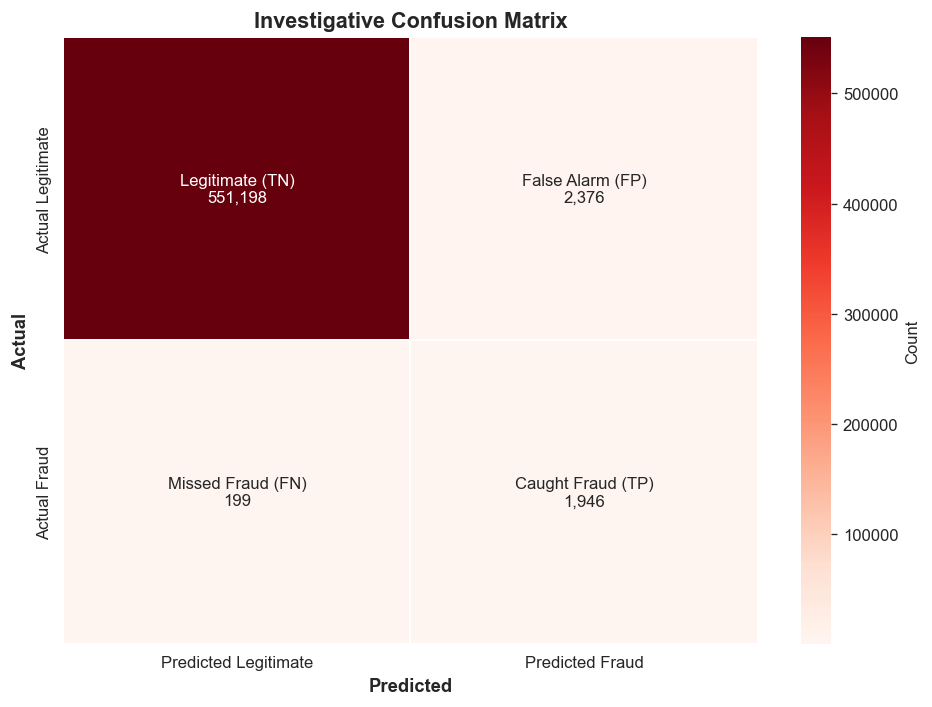

In [33]:
fn_xgb = int(confusion_matrix(y_test, y_pred_xgb).ravel()[2])

print("=" * 55)
print("ADVISORY LIFT REPORT")
print("=" * 55)
print(f"Baseline Missed Cases (Leakage): {fn_dummy}")
print(f"Champion Missed Cases (Leakage): {fn_xgb}")
print(f"Advisory Lift (Transactions Saved): {fn_dummy - fn_xgb}")
print("=" * 55)

# Investigative Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = cm.ravel()

labels = np.array([
    [f'Legitimate (TN)\n{tn:,}', f'False Alarm (FP)\n{fp:,}'],
    [f'Missed Fraud (FN)\n{fn:,}', f'Caught Fraud (TP)\n{tp:,}']
])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm, annot=labels, fmt='', cmap='Reds',
    xticklabels=['Predicted Legitimate', 'Predicted Fraud'],
    yticklabels=['Actual Legitimate', 'Actual Fraud'],
    linewidths=1, cbar_kws={'label': 'Count'}, ax=ax
)
ax.set_title('Investigative Confusion Matrix', fontsize=13, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

## 7.0 Operational Calibration

Model probabilities must be converted into binary decisions using a threshold that balances risk coverage against operational capacity. We analyze the Precision-Recall trade-off to validate the operational standard.

### 7.1 Precision-Recall Analysis

We analyze the Precision-Recall curve. The 0.5 probability threshold is selected as the 'Operational Sweet Spot,' capturing the majority of fraud variance without saturating the manual review team with false alarms.

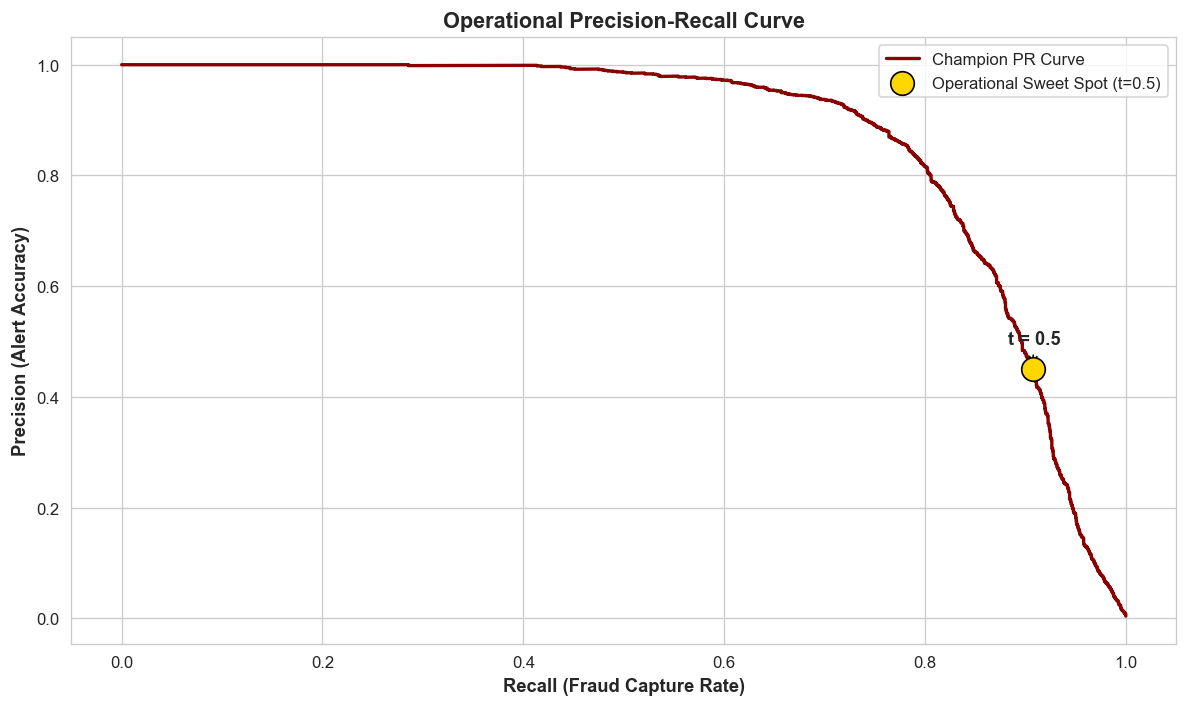

In [34]:
y_proba_xgb = champion_model.predict_proba(X_test)[:, 1]
prec_curve, rec_curve, pr_thresholds = precision_recall_curve(y_test, y_proba_xgb)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(rec_curve, prec_curve, color='darkred', linewidth=2, label='Champion PR Curve')

# Mark the 0.5 threshold operating point
prec_at_05 = precision_score(y_test, y_pred_xgb)
rec_at_05 = recall_score(y_test, y_pred_xgb)
ax.scatter(rec_at_05, prec_at_05, s=200, color='gold', edgecolors='black',
           zorder=5, label='Operational Sweet Spot (t=0.5)')
ax.annotate('t = 0.5', (rec_at_05, prec_at_05),
            textcoords="offset points", xytext=(-15, 15),
            fontsize=11, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='black'))

ax.set_xlabel('Recall (Fraud Capture Rate)', fontsize=11, fontweight='bold')
ax.set_ylabel('Precision (Alert Accuracy)', fontsize=11, fontweight='bold')
ax.set_title('Operational Precision-Recall Curve', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

### 7.2 Residual Risk Audit (Blind Spots)

Despite high performance, a subset of fraud remains undetected. We profile these 'Missed Cases' to understand the model's limitations and guide future feature engineering.

In [35]:
blind_spots = X_test[(y_test.values == 1) & (y_pred_xgb == 0)].copy()

median_loss = blind_spots['spike_factor'].median()

# category_risk is the target-encoded risk score; bucket into quintiles to identify which risk tiers the model struggles with.
blind_spots['risk_band'] = pd.qcut(
    blind_spots['category_risk'], q=5,
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    duplicates='drop'
)
top_categories = blind_spots['risk_band'].value_counts().head(3)

print("=" * 55)
print("RESIDUAL RISK AUDIT — BLIND SPOTS")
print("=" * 55)
print(f"Undetected Risk Count: {len(blind_spots)}")
print(f"Median Value of Missed Transactions (spike_factor proxy): {median_loss:.4f}")
print(f"\nTop 3 Category Risk Bands in Missed Cases:")
for band, count in top_categories.items():
    print(f"  {band}: {count} ({count/len(blind_spots):.1%})")
print("=" * 55)

RESIDUAL RISK AUDIT — BLIND SPOTS
Undetected Risk Count: 199
Median Value of Missed Transactions (spike_factor proxy): -0.2378

Top 3 Category Risk Bands in Missed Cases:
  Very Low: 65 (32.7%)
  High: 43 (21.6%)
  Medium: 36 (18.1%)


## 8.0 Model Explainability (SHAP)

We utilize SHAP (SHapley Additive exPlanations) for feature interpretability. This ensures the model is not a 'Black Box' and validates that decisions are driven by behavioral anomalies.

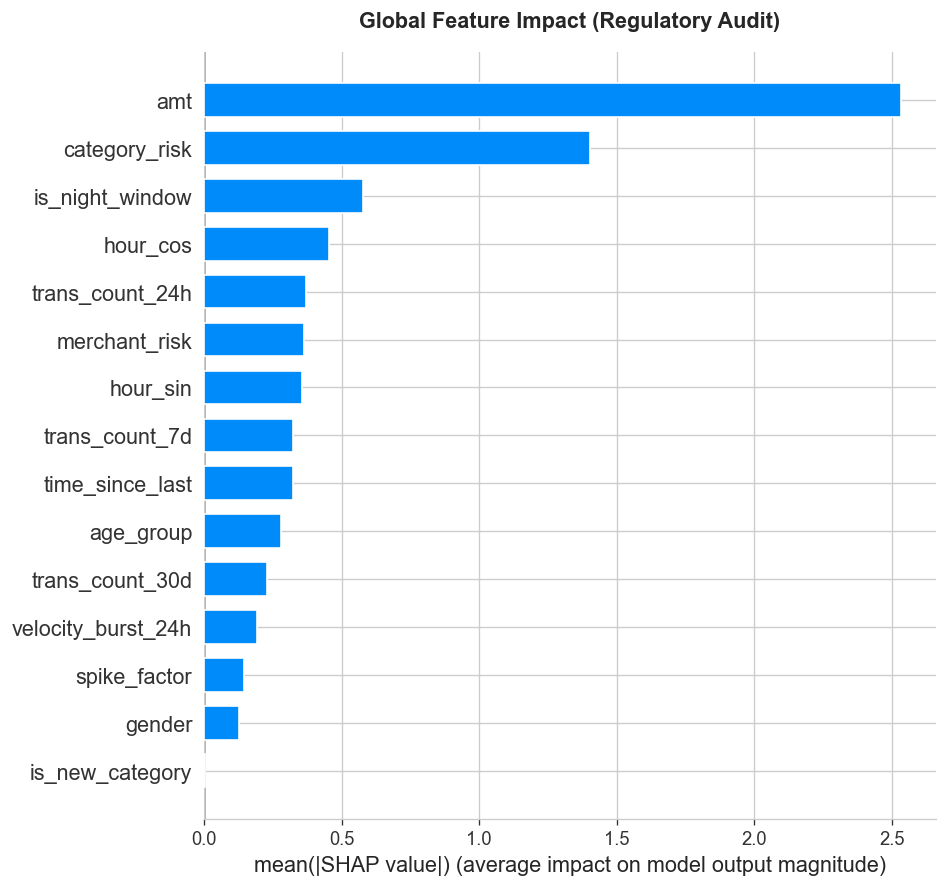

In [37]:
# Efficiency Constraint: Sample 5,000 rows to prevent explainer timeouts.
X_shap = shap.utils.sample(X_test, 5000, random_state=42)

explainer = shap.TreeExplainer(champion_model)
shap_values = explainer.shap_values(X_shap)

plt.figure()
shap.summary_plot(shap_values, X_shap, plot_type='bar', show=False)
plt.title('Global Feature Impact (Regulatory Audit)', fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()